In [9]:
# We collected a dataset from kaggle which conatains 100 normal brain ct scans and 100 intracranial brain hemorrage ct scans 
# I stored them in the folder dlhccc... So dlhccc folder contains head_ct scans folder and labels.csv file
import numpy as np 
import pandas as pd 



import os
for dirname, _, filenames in os.walk('./DATASET'): # using walk method in os module i printed all the files in the current directory
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/dlhccc/labels.csv
/kaggle/input/dlhccc/head_ct/head_ct/173.png
/kaggle/input/dlhccc/head_ct/head_ct/043.png
/kaggle/input/dlhccc/head_ct/head_ct/038.png
/kaggle/input/dlhccc/head_ct/head_ct/069.png
/kaggle/input/dlhccc/head_ct/head_ct/083.png
/kaggle/input/dlhccc/head_ct/head_ct/074.png
/kaggle/input/dlhccc/head_ct/head_ct/027.png
/kaggle/input/dlhccc/head_ct/head_ct/148.png
/kaggle/input/dlhccc/head_ct/head_ct/177.png
/kaggle/input/dlhccc/head_ct/head_ct/142.png
/kaggle/input/dlhccc/head_ct/head_ct/104.png
/kaggle/input/dlhccc/head_ct/head_ct/053.png
/kaggle/input/dlhccc/head_ct/head_ct/007.png
/kaggle/input/dlhccc/head_ct/head_ct/133.png
/kaggle/input/dlhccc/head_ct/head_ct/162.png
/kaggle/input/dlhccc/head_ct/head_ct/186.png
/kaggle/input/dlhccc/head_ct/head_ct/089.png
/kaggle/input/dlhccc/head_ct/head_ct/153.png
/kaggle/input/dlhccc/head_ct/head_ct/023.png
/kaggle/input/dlhccc/head_ct/head_ct/167.png
/kaggle/input/dlhccc/head_ct/head_ct/092.png
/kaggle/input/dlhccc/he

In [10]:
# here I imported all the modules which are required for data augumentation and building the ML model
import os
from os import listdir
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader, random_split    
from sklearn.model_selection import train_test_split

import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

from PIL import Image,ImageEnhance
import random
import warnings
warnings.filterwarnings("ignore")

In [11]:
# To show how the label are there in labels.csv file  i printed the first 5 labels using head method in dataframes

labels = pd.read_csv('./DATASET/labels.csv')
labels.head()



,id,hemorrhage
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


In [12]:


labels.rename(columns={' hemorrhage': 'hemorrhage'}, inplace=True)



In [13]:
# Here i am appending the values at the id coulmn  with .png extension
labels['id'] = labels['id'].astype(int) 
labels['id'] = labels['id'].apply(lambda x: str('%03d' % x) + ".png")  
labels.head()

,id,hemorrhage
0,000.png,1
1,001.png,1
2,002.png,1
3,003.png,1
4,004.png,1


In [14]:
#  Just to make sure that number of labels = 2 and labels are 0 and 1  ...... i printed the unique labels

classes=list(labels['hemorrhage'].unique())
classes




[1, 0]

In [15]:
# since the dataset contains only 200 images(which is very low) i cant do much with that.... so i need to increase the data 

# so i defined apply_augumentation function which will take an image and generate new image by brightness enhancement ,contrast enhancemenats and so on

def apply_augmentation(image):
    
    angle=random.randint(-20,20)     # here i am rotating the image  based on the random input generated
    augmented_image=image.rotate(angle)
    
    if(random.random()>0.5):
        augmented_image=augmented_image.transpose(Image.FLIP_LEFT_RIGHT)
    
    brightness_factor=random.uniform(0.85,1.15)  # here i am generating a random number from uniform distribution (0.85 , 1.15) 
    enhanced_image= ImageEnhance.Brightness(augmented_image).enhance(brightness_factor) #based on the value it generated i am changing the brightness of the image
    
    contrast_factor = random.uniform(0.85, 1.15) 
    enhanced_image = ImageEnhance.Contrast(enhanced_image).enhance(contrast_factor)
    
    color_image = ImageEnhance.Color(enhanced_image).enhance(random.uniform(0.8, 1.2))
    
   # just like brightness enhancments i am also enchancing the contrast and color
    
    scale_factor=random.uniform(0.8,1.2)
    new_size=(int(color_image.width * scale_factor),int(color_image.height * scale_factor))
    
    # Now i am scaling the image
    
    new_image=color_image.resize(new_size,Image.NEAREST)
    
    # And returing the enchanced image
    return new_image


In [16]:
directory = "data-augmentation" # i created a folder named data- augumentation to store the newly produced images
parent_dir = "./"
path = os.path.join(parent_dir,directory)
os.mkdir(path)

input_dir = "./DATASET/head_ct/"
output_dir = "./data-augmentation/"
image_num = 6        # Now for each image in the dataset i am generating 6 new images and storing them in the data-augumenattion folder
    
for files in listdir(input_dir):
    if(files.endswith(".png")):
        input_path=os.path.join(input_dir, files)
        image=Image.open(input_path).convert("L")
                
        for i in range(image_num):
            augmented_image = apply_augmentation(image)  # Now i am calling the apply_augumenatation function which I defined earlier
            output_file = f"{os.path.splitext(files)[0]}_{i}.png"
            output_path = os.path.join(output_dir, output_file)
            augmented_image.save(output_path)

In [17]:
# earlier we increased only he number of images.. now we are going to increase the labels by giving the label of parent image for all the 6 images 
# produced from the same parent image
expanded_labels = pd.DataFrame(columns=['id', 'hemorrhage'])
for index, row in labels.iterrows():
    img_id = row['id'].replace('.png', '')   
    hemorrhage_label = row['hemorrhage']
    for i in range(6): 
        new_img_id = f"{img_id}_{i}.png"
        new_row = {'id': new_img_id, 'hemorrhage': hemorrhage_label}
        expanded_labels = pd.concat([expanded_labels, pd.DataFrame(new_row, index=[0])], ignore_index=True)

expanded_labels.to_csv('./expanded_labels.csv', index=False)  

In [18]:
expanded_labels.tail(10) # now we can see  that there are 1200(which is nothing but 200*6) images  with there respective labels 

,id,hemorrhage
1190,198_2.png,0
1191,198_3.png,0
1192,198_4.png,0
1193,198_5.png,0
1194,199_0.png,0
1195,199_1.png,0
1196,199_2.png,0
1197,199_3.png,0
1198,199_4.png,0
1199,199_5.png,0


In [19]:
# Now i am spliting the train and test data ( i am taking 90% of the data as train data  and remaing 10% data as test data)

from sklearn.model_selection import train_test_split

train_label_df, test_label_df = train_test_split(expanded_labels, test_size=0.10,shuffle=True)
train_label_df.to_csv ('./train_csv.csv', index = False, header=True)
test_label_df.to_csv ('./test_csv.csv', index = False, header=True)



In [20]:
# i created a class CTDataset to store the location of the image , transformed images and labels for that images

from torch.utils.data import Dataset, DataLoader
from PIL import Image

class CTDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotation_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(self.root_dir+ img_id).convert("L")
        y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)



In [21]:
# we are defining what to do when we use transform as an parameter for any function
#it bascially Compresses the images  into 224 * 224 and normalizes the pixels value
transform = transforms.Compose(
    [transforms.Resize((224,224)),transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

In [22]:
#here with a batch size of 10.... i am regrouping the training images and testing images
batch_size = 10 
num_workers = 4
trainset = CTDataset(root_dir='./data-augmentation/', 
                     annotation_file='./train_csv.csv', 
                     transform=transform)

trainloader = DataLoader(trainset, 
                         batch_size=batch_size,
                         shuffle=True, 
                         num_workers=num_workers, 
                         drop_last=True)

testset = CTDataset(root_dir='./data-augmentation/', 
                    annotation_file='./test_csv.csv', 
                    transform=transform)

testloader = DataLoader(testset, 
                        batch_size=batch_size,
                        shuffle=False, 
                        num_workers=num_workers)

In [23]:
images, labels = next(iter(trainloader))

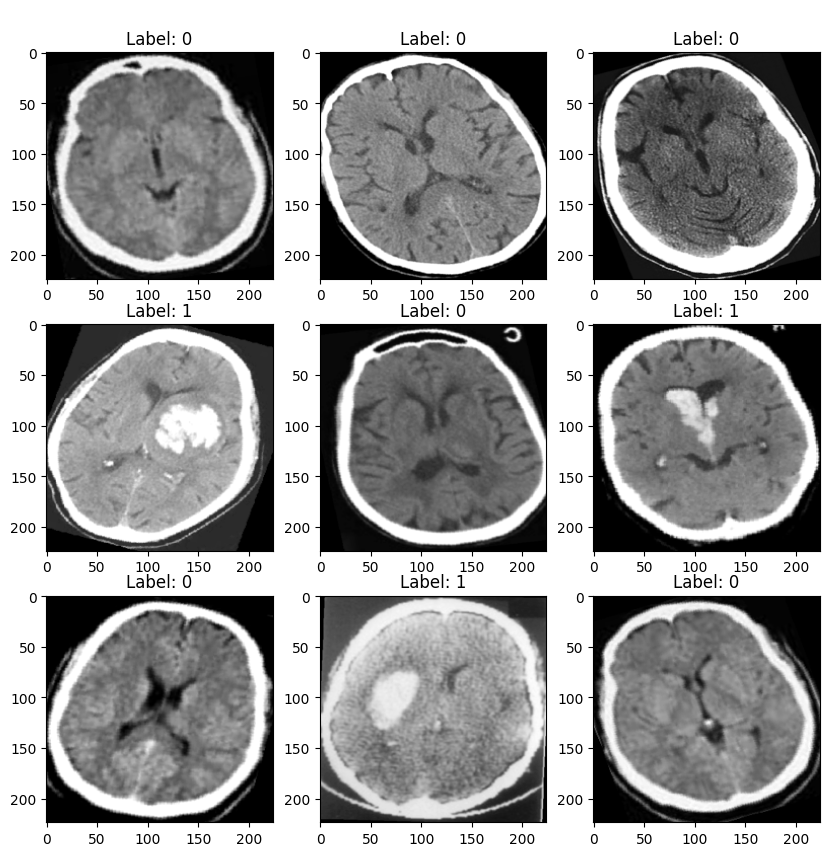

In [25]:
# now i am plotting few newly generated images for our visulazation
plt.figure(figsize=(10, 10))
for i in range(0,9):
    plt.subplot(331 + i)
    plt.imshow(images[i][0], cmap="gray")
    plt.title("\nLabel: 0" if labels[i] == 0 else "Label: 1")

In [26]:
# using pytorch i am building my model
 
#This model contains 3 convolution layers and 3 Fully connected layers
from torch import nn
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.model=nn.Sequential(
            nn.Conv2d(1,64,(3,3)),  # in the 1st convolution layer i am taking 64 kernels each of 3 * 3 dimensions followed by relu activation
            nn.ReLU(),
            nn.Conv2d(64,256,(3,3)), # in the 2nd convolution layer i am taking 256 kernels each of 3 * 3 * 64 dimensions followed by relu activation
            nn.ReLU(),
            nn.Conv2d(256,64,(3,3)), # in the 3rd  convolution layer i am taking 64 kernels each of 3 * 3 * 256 dimensions followed by relu activation
            nn.ReLU(),
            nn.Flatten(), 
            nn.Linear(64*(224-6)*(224-6), 64), # After that i flattened the output of 3rd convolution layer and fully connected to the 64 neurons 
            nn.Linear(64,64), # Again a fully connected layer with 64 neurons
            nn.Linear(64,2) # in the output layer number of neurons should match the number of classes so i am taking 2 neurons in the output layer
            )
    def forward(self,x):
        return self.model(x)


In [27]:
device='cpu'
from torch.optim import Adam
model = Classifier().to(device)
optimizer = Adam(model.parameters(),lr=0.00001) # here we are using adam optimizier as the optimizer and loss function is binary cross entropy
criterion=nn.CrossEntropyLoss() 

In [36]:
# Train The Model 
num_epochs = 1

predictions=[]
actual_labels=[]


for epoch in range(num_epochs):
    train_loss = 0
    train_correct = 0
    train_samples = 0
    for images, labels in trainloader:
        images = images.to(device)
        outputs = model(images)
        labels = labels.to(outputs.device).long()   # here i am training the model using the train dataset 
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_samples += labels.size(0)
      
     
    val_loss = 0
    val_correct = 0
    val_samples = 0
   
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device).long()

            outputs = model(images)                           # here i am predicting the labels of test dataset based on the learning of our model 
            _, predicted = torch.max(outputs.data, 1)
            
           

            val_correct += (predicted == labels).sum().item()
            val_samples += labels.size(0)
            
            predictions.extend(predicted.cpu().numpy())
            actual_labels.extend(labels.cpu().numpy())
            
            
            
    results_df=pd.DataFrame({"Actual":actual_labels,"Predicted":predictions}) # i am storing the actual labels 
    # and predicted labels in the results_df dataframe so that i can use that in future 
    train_loss /= len(trainloader)
    train_accuracy = train_correct / train_samples
    val_loss /= len(testloader)
    val_accuracy = val_correct / val_samples
    
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch [1/1], Train Loss: 0.2708, Train Accuracy: 0.8991, Validation Loss: 0.0000, Validation Accuracy: 0.8583


In [32]:


results_df

# here we can see the actual labels and predicted labels stored in results_df dataframe

,Actual,Predicted
0,1,0
1,0,0
2,0,0
3,1,0
4,1,0
...,...,...
115,1,1
116,0,0
117,1,1
118,0,0


In [33]:
TP = 0
TN = 0
FP = 0
FN = 0
 
# based on the definition of true positive,true negative ,false positive and false negative  i am finding there values 
for i in range(120):
    if results_df["Actual"][i] == results_df["Predicted"][i] and results_df["Predicted"][i] == 1:
        TP+=1
    elif results_df["Actual"][i] == results_df["Predicted"][i]:
        TN += 1
    elif results_df["Predicted"][i] == 1:
        FP += 1
    else:
        FN += 1

        
print(TP)
print(TN)
print(FP)
print(FN)
        
# here Tp = 40, TN = 56 , FP = 1 and FN = 23 

# these values will change from the one run to other run.....This is because we are randomly spliting the data

#So these values are not the same values which we mentioned in ppt

40
56
1
23


In [34]:
# here using the definition of recall,specificity, precision and F1_score i am finding there values 
recall  = TP/(TP+FN)
specificity = TN/(TN+FP)
precision = TP/(TP+FP)
F1_score = 2*precision*recall/(precision + recall)

print(recall)
print(specificity)
print(precision)
print(F1_score)

# i obtained 
#recall = 0.634
#specificity = 0.982
#precision = 0.975
# F1_score = 0.7692

0.6349206349206349
0.9824561403508771
0.975609756097561
0.7692307692307692
